# EDA

## Imports

In [122]:
# Your code here
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt 
import json
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import f_classif, SelectKBest
from pickle import dump
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

## 1. Data collection

- What can we learn about different hosts and areas?
- What can we learn from predictions? (ex: locations, prices, reviews, etc)
- Which hosts are the busiest and why?
- Is there any noticeable difference of traffic among different areas and what could be the reason for it?

In [123]:
df = pd.read_csv("/workspace/airbnb_eda/data/raw/AB_NYC_2019.csv")
df.head(3)

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365


___

## 2. Exploration and Data cleaning

### 2.1 Understanding the features:

***n - numerical || c - categorical***

- 'id' - Rental ID -> n
- 'name' - House/Apartment name -> c
- 'host_id' - Host ID -> n
- 'host_name' - Host Name -> c
- 'neighbourhood_group' - NYC Region -> c
- 'neighbourhood' - NYC Neighbourhood -> c
- 'latitude' - Lat -> n
- 'longitude' - Lon -> n
- 'room_type' - Room type -> c
- 'price' - Price per night -> n
- 'minimum_nights' - Minimum stay nights -> n
- 'number_of_reviews' - Total number of reviews -> n
- 'last_review' - Last time reviewed -> n
- 'reviews_per_month' - Reviews per month -> n
- 'calculated_host_listings_count' - Total listings by the same host -> n
- 'availability_365' - Days available during a year -> n

In [124]:
print(f"Our dataframe contains {len(df)} rows, inditating the total umber of rentals, and has a shape of {df.shape}")

Our dataframe contains 48895 rows, inditating the total umber of rentals, and has a shape of (48895, 16)


### 2.2 Identifying Null Values and data types for each feature

In [125]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     

In terms of types of data, we have:

- **5 Categorical Characteristics** -> (name, host_name, neighbourhood_group, neighbourhood, room_type)
- **11 Numerical Characteristics** -> (id, host_id, latitude, longitude, price, minimum_nights, number_of_reviews, last_review, reviews_per_month, calculated_host_listings_count, availability_365)

In [126]:
df.isna().sum().loc[lambda x: x > 0]

name                    16
host_name               21
last_review          10052
reviews_per_month    10052
dtype: int64

Conclusions:

- We have 16 Nulls in our 'name' feature -> Considering this is the 'apartment/rental name,' we do a 'fillna()' with any name; we will analyze later if this has repercussions when renting the apartment.  
- We have 21 Nulls in our 'host_name' feature -> We will check if these hosts have other locations on rent using the host_id so that we can complete the names.
- 'last_review' and 'reviews_per_month' have 10052 Nulls -> This might be new locations added recently that have not been rented yet. We will try to get more info while looking at the data.

### 2.3 Looking for duplicated IDs and dropping them, if any

In [127]:
print(f"Duplicated IDs: {df['id'].duplicated().sum()}")

Duplicated IDs: 0


### 2.4 Eliminating Irrelevant Information and dealing with null values

In [128]:
df.drop(["id", "name", "host_name", "host_id", "last_review"], axis=1, inplace=True)
df.head(3)

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,0.21,6,365
1,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,0.38,2,355
2,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,1,365


As we can see, we are almost done with data cleaning. However, we still have one feature that contains many NaN values. This means that we will fill them with 0.

*Reasoning behind dropping those features and filling with zero our 'reviews_per_month' feature:*

- **'id' / 'name' / host_id /'host_name'** - These are mainly identifiers in our database and are not associated with the frequency of rentals at each location. In the case of 'name' and 'host_name,' null values can be found, which gave us an additional reason to remove them.
- **'last_review'** - Considering we do not have other dates to associate this with, we decided to drop this feature as other relevant information related to reviews is found in our data frame ('number_of_reviews').
- **'reviews_per_month'** - It seems that the only reason that feature can be null is that they have not gotten any reviews yet; therefore, instead of dropping those rows, a decision was taken to fill them with zero.

In [129]:
df.isna().sum()

neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

In [130]:
df["reviews_per_month"] = df["reviews_per_month"].fillna(0)
df.isna().sum()

neighbourhood_group               0
neighbourhood                     0
latitude                          0
longitude                         0
room_type                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
dtype: int64

---

## 3. Univariate Analysis

### 3.1 Dividing our dataset into categorial and numerical

Understanding how many type of feature we have

In [131]:
df.dtypes.unique()

array([dtype('O'), dtype('float64'), dtype('int64')], dtype=object)

Dividing pur dataframe by numerical and categorical features

In [132]:
num = ["int64", "float64"]
cat = ["O"]

df_num = df.select_dtypes(num)
df_cat = df.select_dtypes(cat)

In [133]:
df_num.head(3)

,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,40.64749,-73.97237,149,1,9,0.21,6,365
1,40.75362,-73.98377,225,1,45,0.38,2,355
2,40.80902,-73.94190,150,3,0,0.00,1,365


In [134]:
df_cat.head(3)

,neighbourhood_group,neighbourhood,room_type
0,Brooklyn,Kensington,Private room
1,Manhattan,Midtown,Entire home/apt
2,Manhattan,Harlem,Private room


### 3.2 Categorical Variable Analysis

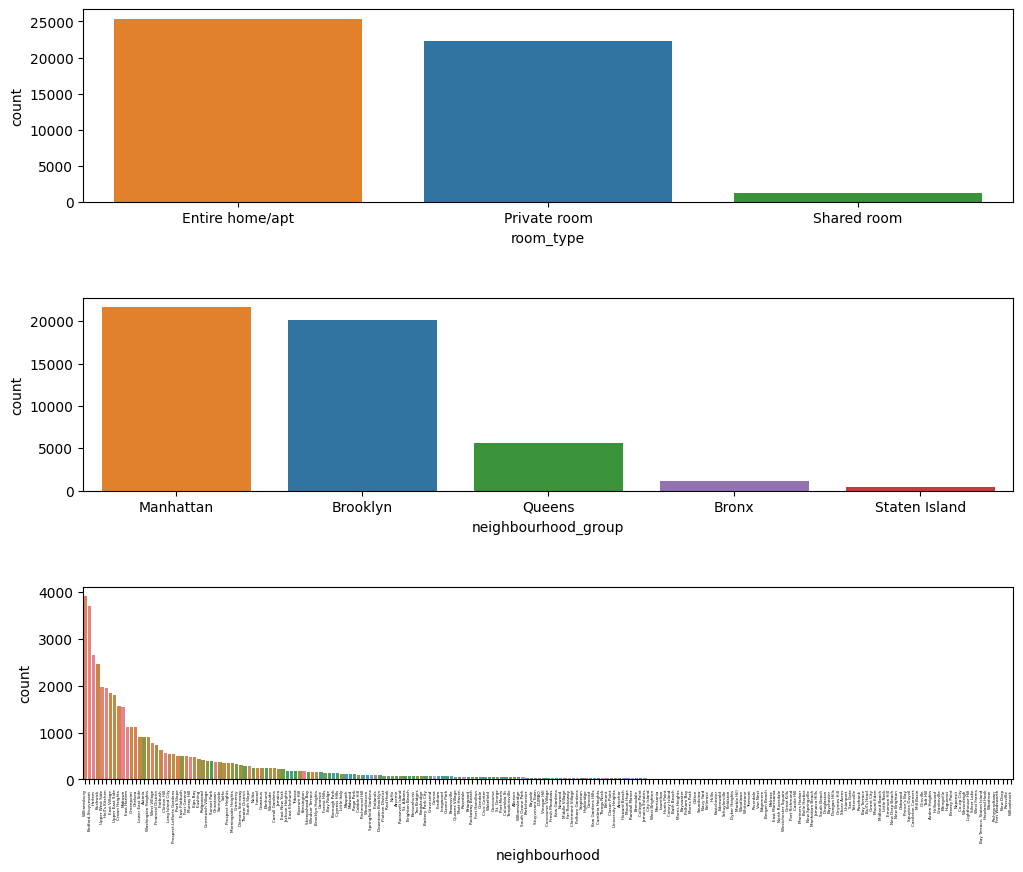

In [135]:
fig, ax = plt.subplots(3, 1, figsize = (12, 10))
sns.countplot(ax = ax[0], data = df_cat, x = "room_type", order=df_cat['room_type'].value_counts().index, hue='room_type')
sns.countplot(ax = ax[1], data = df_cat, x = "neighbourhood_group", order=df_cat['neighbourhood_group'].value_counts().index, hue='neighbourhood_group')
sns.countplot(ax = ax[2], data = df_cat, x = 'neighbourhood', order=df_cat['neighbourhood'].value_counts().index, hue='neighbourhood')
plt.xticks(rotation=90, fontsize=3)
plt.subplots_adjust(hspace=0.5)
plt.show()

**Conclusions**  

- Most Airbnb listings are either entire homes/apartments or private rooms, indicating a focus on attracting tourists who value privacy.  
- Manhattan and Brooklyn are the most popular locations for Airbnb rentals, likely due to their central locations and high demand from tourists.  
- Specific neighborhoods like Williamsburg and Bedford-Stuyvesant stand out in popularity, possibly because they offer a mix of affordability and proximity to central areas.

### 3.3 Numerical Variable Analysis

In [136]:
#Variables
df_num.head(3)

,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,40.64749,-73.97237,149,1,9,0.21,6,365
1,40.75362,-73.98377,225,1,45,0.38,2,355
2,40.80902,-73.94190,150,3,0,0.00,1,365


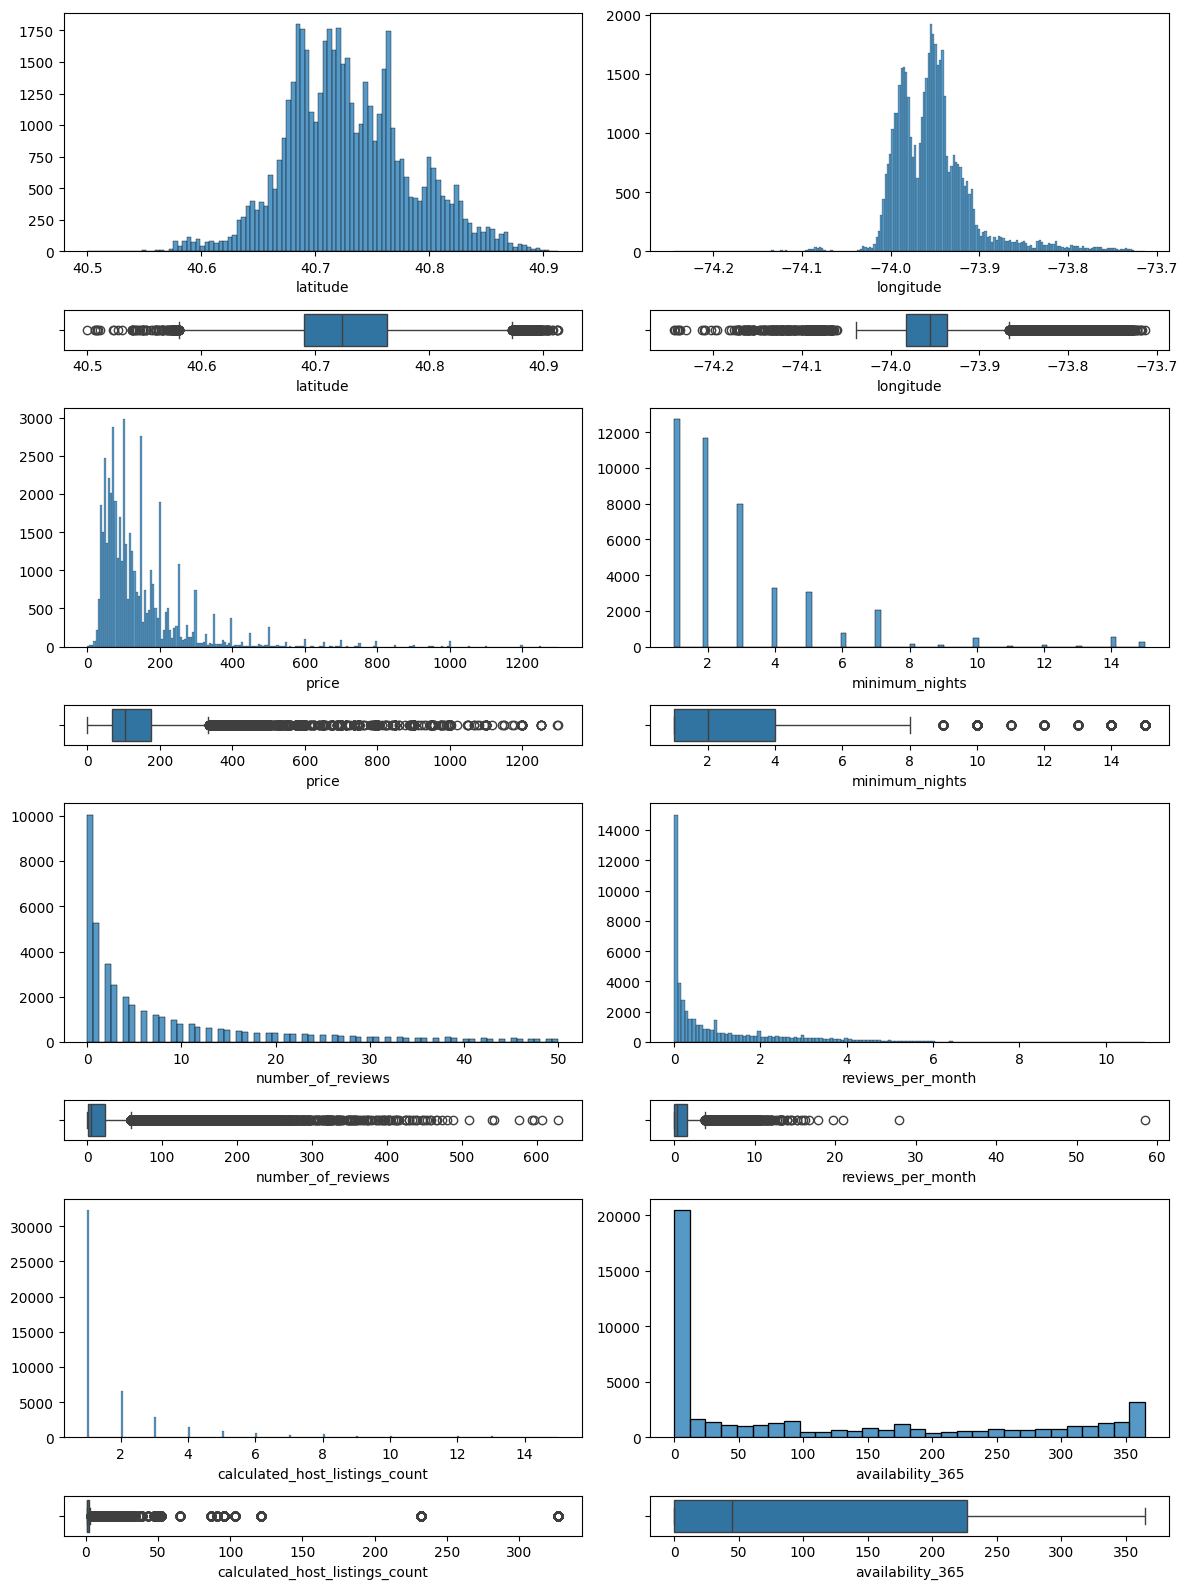

In [137]:
fig, ax = plt.subplots(8, 2, figsize=(12, 16), gridspec_kw={'height_ratios': [6, 1, 6, 1, 6, 1, 6, 1]})

#First row of charts
sns.histplot(ax = ax[0,0], data = df_num, x = "latitude").set(ylabel = None)
sns.boxplot(ax = ax[1,0], data = df_num, x = "latitude")
sns.histplot(ax = ax[0,1], data = df_num, x = "longitude").set(ylabel = None)
sns.boxplot(ax = ax[1,1], data = df_num, x = "longitude")

#Second row of charts
sns.histplot(ax = ax[2,0], data = df_num[df_num["price"]<1300], x = "price").set(ylabel = None)
sns.boxplot(ax = ax[3,0], data = df_num[df_num["price"]<1300], x = "price")
sns.histplot(ax = ax[2,1], data = df_num[df_num["minimum_nights"]<16], x = "minimum_nights").set(ylabel = None)
sns.boxplot(ax = ax[3,1], data = df_num[df_num["minimum_nights"]<16], x = "minimum_nights")

# Charts third row 
sns.histplot(ax = ax[4,0], data = df_num[df_num['number_of_reviews']<51], x='number_of_reviews').set(ylabel = None)
sns.boxplot(ax = ax[5,0], data = df_num, x='number_of_reviews')
sns.histplot(ax = ax[4,1], data = df_num[df_num['reviews_per_month']<11], x='reviews_per_month').set(ylabel = None)
sns.boxplot(ax = ax[5,1], data = df_num, x='reviews_per_month')

# Charts last row 
sns.histplot(ax = ax[6,0], data = df_num[df_num['calculated_host_listings_count']<16], x='calculated_host_listings_count').set(ylabel = None)
sns.boxplot(ax = ax[7,0], data = df_num, x='calculated_host_listings_count')
sns.histplot(ax = ax[6,1], data = df_num, x='availability_365').set(ylabel = None)
sns.boxplot(ax = ax[7,1], data = df_num, x='availability_365')

plt.tight_layout()
plt.show()

**Conclusions**
  
- The distributions of latitude and longitude indicate a central clustering of Airbnb listings in the most popular areas of New York City.  
- Most properties are relatively affordable, with rates primarily between 100 USD and 200 USD per night, although some high-end listings are priced significantly higher.  
- A majority of listings have a low minimum night requirement, making them appealing for short-term stays, though a few require longer stays.  
- The distribution of total reviews and reviews per month suggests that most listings receive only a small number of reviews, which may indicate infrequent bookings or that they are newer listings.  
- Most hosts manage only one or two properties, suggesting that listings are largely from individuals or small-scale operators, though some outliers manage a significant number of properties.  
- The bimodal distribution of availability suggests that certain listings are either consistently available or mostly inactive, indicating a mix of dedicated hosts and potentially seasonal or inactive listings.

---

## 4. Multivariate Analysis

### 4.1 Encoding Categorical Values and Saving JSON files

In [138]:
ng = list(df["neighbourhood_group"].unique())
neighbourhood_group_encoded = dict(zip(ng, list(range(len(ng)))))

with open("./enc/neighbourhood_group_encoded.json", "w") as f:
    json.dump(neighbourhood_group_encoded, f)

In [139]:
n = list(df['neighbourhood'].unique())
neighbourhood_encoded = dict(zip(n, list(range(len(n)))))

with open('./enc/neighbourhood_encoded.json', 'w') as f:
    json.dump(neighbourhood_encoded, f)

In [140]:
rt = list(df['room_type'].unique())
room_type_encoded = dict(zip(rt, list(range(len(rt)))))

with open('./enc/room_type_encoded.json', 'w') as f:
    json.dump(room_type_encoded, f)

In [141]:
df_enc = df.copy()

In [142]:
df_enc['neighbourhood_group_encoded'] = df_enc['neighbourhood_group'].map(neighbourhood_group_encoded)
df_enc['neighbourhood_encoded'] = df_enc['neighbourhood'].map(neighbourhood_encoded)
df_enc['room_type_encoded'] = df_enc['room_type'].map(room_type_encoded)
df_enc.drop(columns=['neighbourhood_group', 'neighbourhood', 'room_type'], inplace=True)
df_enc.head(3)

,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,neighbourhood_group_encoded,neighbourhood_encoded,room_type_encoded
0,40.64749,-73.97237,149,1,9,0.21,6,365,0,0,0
1,40.75362,-73.98377,225,1,45,0.38,2,355,1,1,1
2,40.80902,-73.94190,150,3,0,0.00,1,365,1,2,0


### 4.2 Numerical - Numerical Analysis

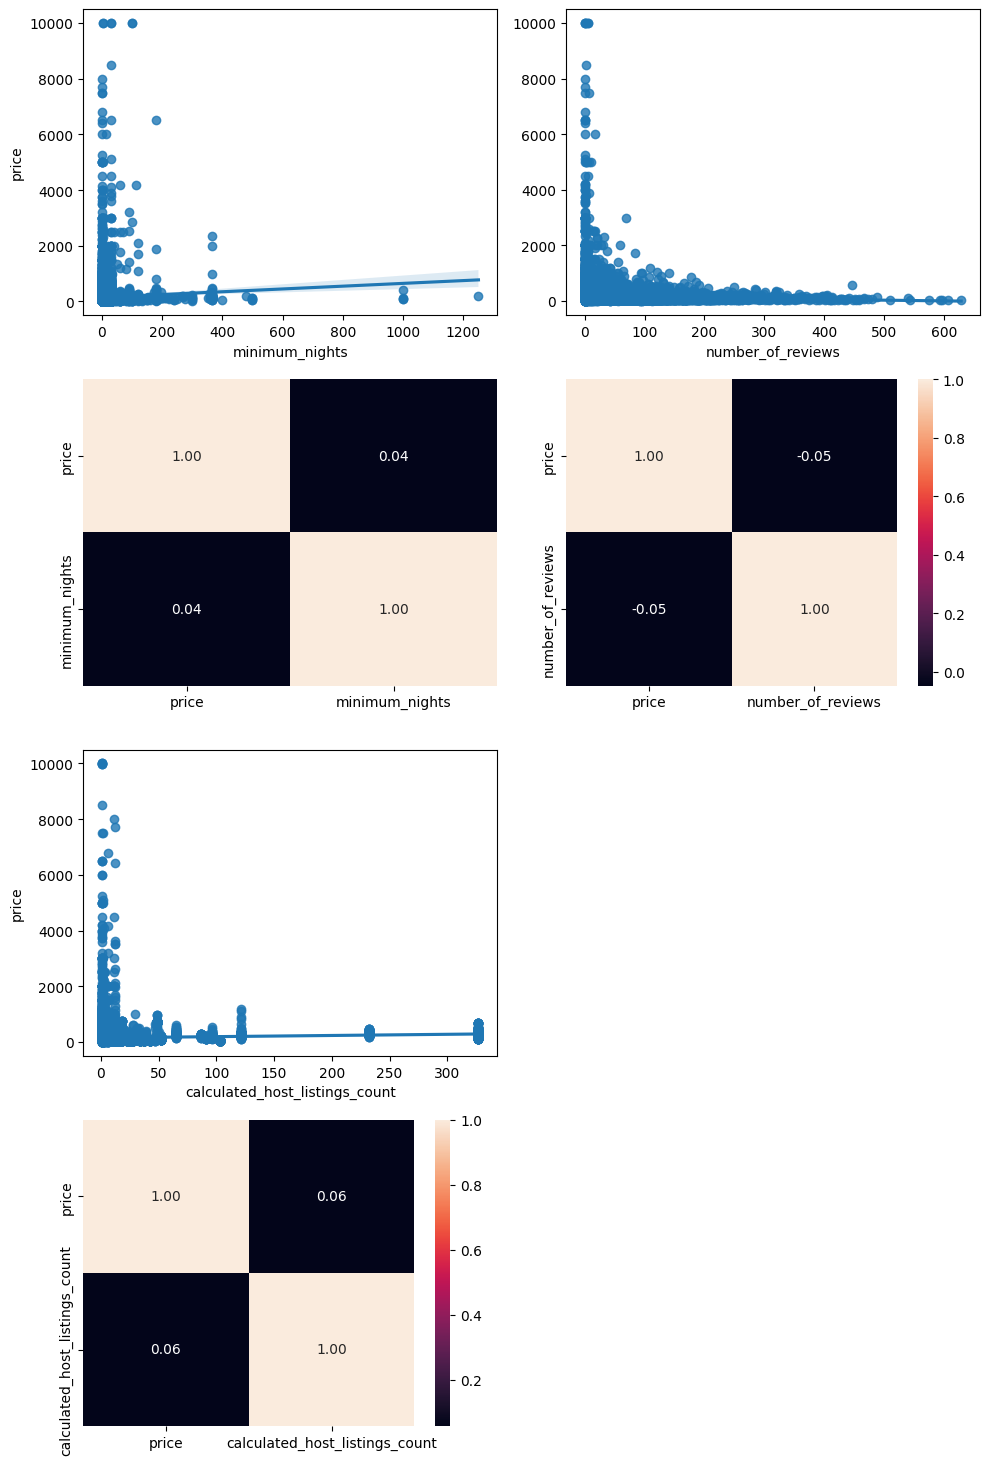

In [143]:
fig, axis = plt.subplots(4,2, figsize = (10,15))

# Minimum nights correlationed with price
sns.regplot(ax = axis[0,0], data = df_enc, x = df_enc["minimum_nights"], y = "price")
sns.heatmap(ax = axis[1, 0], data = df_enc[["price", "minimum_nights"]].corr(), annot = True, fmt = ".2f", cbar = False)

# Number of reviews correlationed with price
sns.regplot(ax = axis[0,1], data = df_enc, x = df_enc["number_of_reviews"], y = df_enc["price"]).set(ylabel = None)
sns.heatmap(ax = axis[1,1], data = df_enc[["price", "number_of_reviews"]].corr(), annot = True, fmt = ".2f")

# Calculated host listings count correlationed with price
sns.regplot(ax = axis[2,0], data = df_enc, x = df_enc["calculated_host_listings_count"], y = "price")
sns.heatmap(ax = axis[3, 0], data = df_enc[["price", "calculated_host_listings_count"]].corr(), annot = True, fmt = ".2f")

fig.delaxes(axis[2, 1])
fig.delaxes(axis[3, 1])

# Adjust layout
plt.subplots_adjust(wspace=0.5)
plt.subplots_adjust(hspace=0.5)
plt.tight_layout()

#Show
plt.show()


**CONCLUSION**

- There's no relation between the price and minimum number of nights
- There's no relation between the number of reviews and the price


### 4.3 Categorical - Categorical analysis

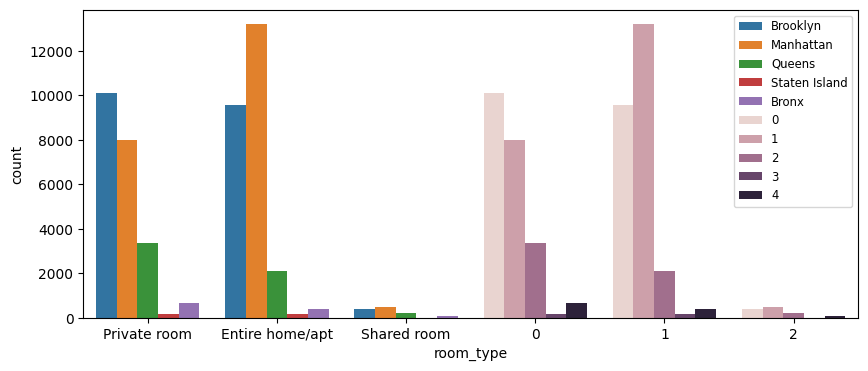

In [144]:
fig, axis = plt.subplots(figsize = (10,4))

#No encoded
sns.countplot(data = df, x = "room_type", hue = "neighbourhood_group")
#Encoded
sns.countplot(data = df_enc, x = "room_type_encoded", hue = "neighbourhood_group_encoded")

#Show
plt.legend(fontsize='small')
plt.show()

**CONCLUSION**

- Manhattan has the highest number of rentals available and also the most Entire Homes/Apartments for rent
- Brooklyn is the second largest rental area, but it has more Private Rooms, which likely suggests that more residents are either sharing their homes or looking to maximize space
- Queens and the Bronx come in third and fourth and follow a similar pattern to Brooklyn
- Staten Island has very few listings and isn’t particularly popular for Airbnb rentals

### 4.4 Numerical - Categorical analysis

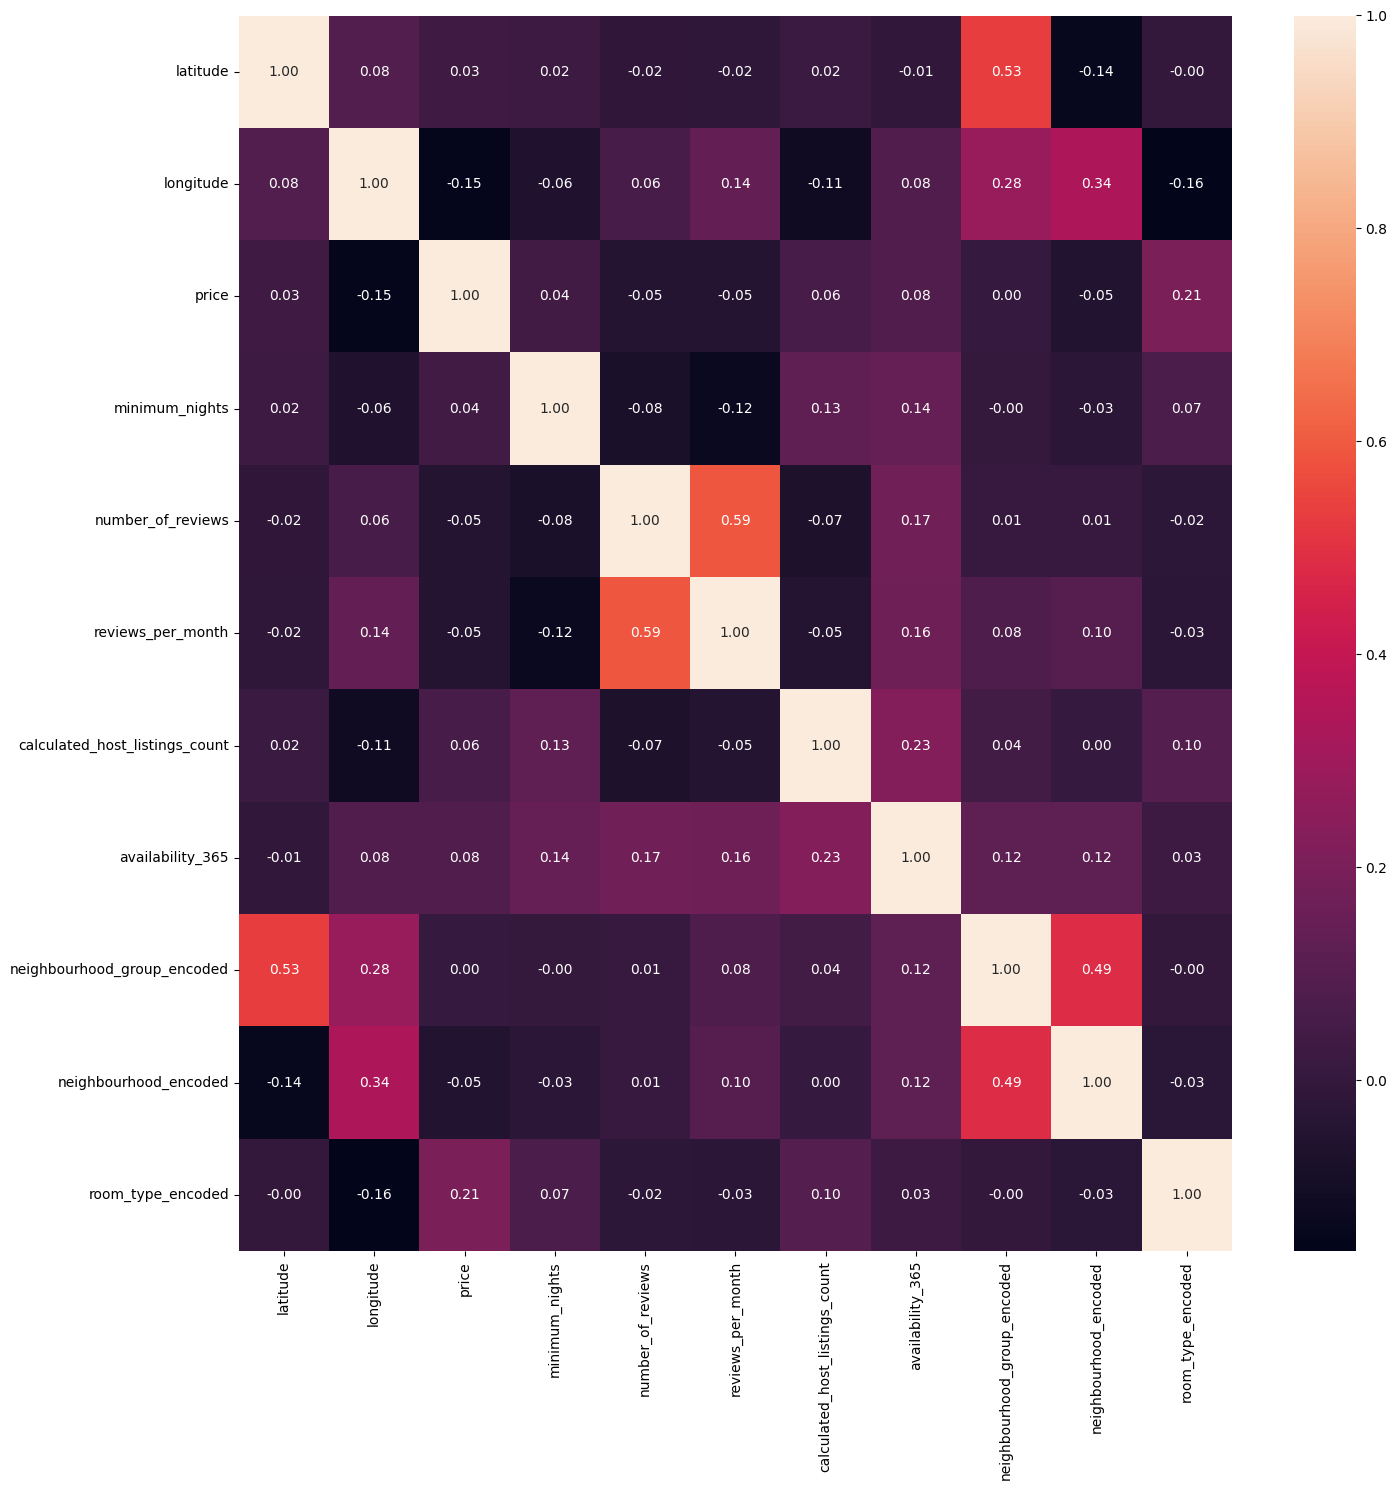

In [145]:

fig, axes = plt.subplots(figsize=(15, 15))

sns.heatmap(df_enc.corr(), annot = True, fmt = ".2f")

#Adjust
plt.tight_layout()

#Show
plt.show()

**CONCLUSION**

Here are the five most notable observations from the correlation heatmap:

- `number_of_reviews` and ``reviews_per_month`` have a strong positive correlation ``(0.59)``: This strong correlation indicates that listings with more total reviews tend to have a higher number of monthly reviews as well. This makes sense, as a high volume of reviews usually implies high booking activity.

- ``neighbourhood_group_encoded`` and ``latitude`` have a moderate positive correlation ``(0.53)``: This suggests that certain neighborhood groups may be geographically clustered along similar latitudes, potentially reflecting location trends within the city.

- ``neighbourhood_group_encoded`` and ``neighbourhood_encoded`` have a significant positive correlation ``(0.49)``: This correlation is logical since individual neighborhoods are naturally associated with larger neighborhood groups. In other words, specific neighborhoods belong to certain areas, which is reflected in this relationship.

- ``latitude`` and ``neighbourhood_encoded`` have a moderate negative correlation ``(-0.14)``: Although this correlation is not very strong, it may indicate that some neighborhoods tend to be located at specific latitudes. As we move along the latitude axis, the neighborhoods change.

- ``price`` and ``room_type_encoded`` have a low positive correlation ``(0.21)``: This slight correlation suggests that the room type (entire home, private room, shared room) may have a small influence on price, with certain room categories likely costing more than others.

### 4.5 Analysing all the Data at Once

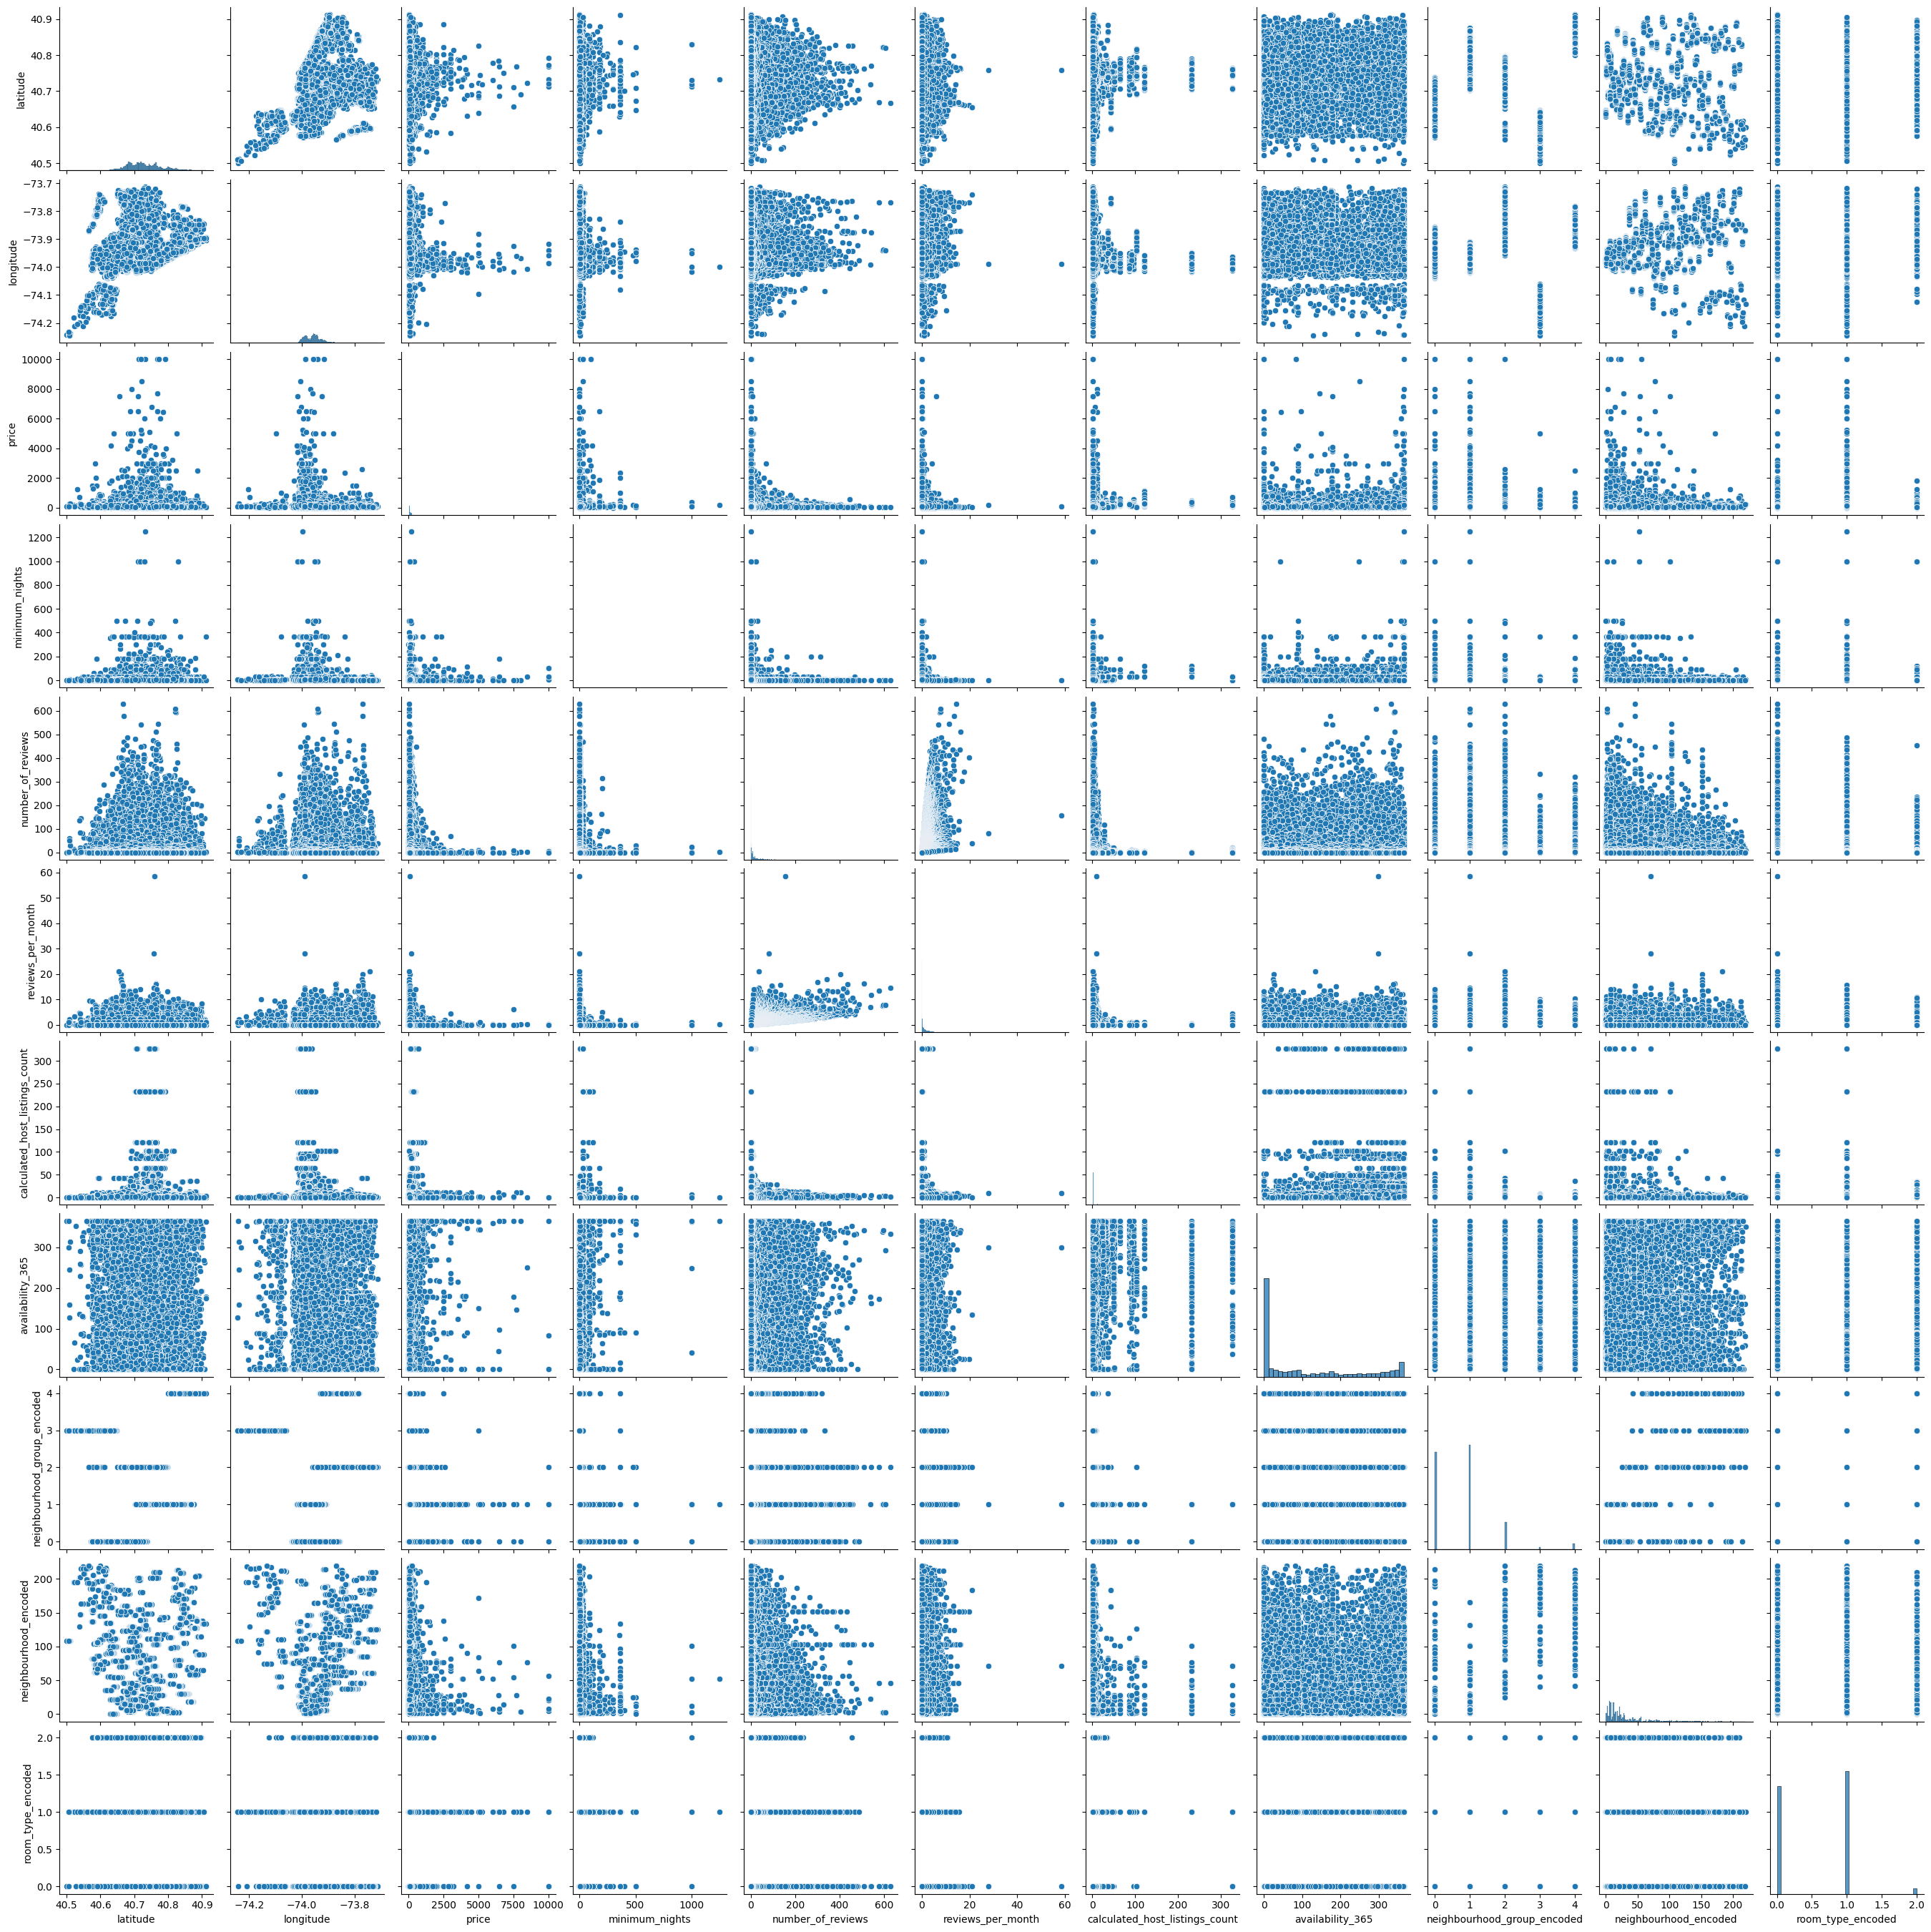

In [146]:
sns.pairplot(data=df_enc)
plt.show()

---

## 5 Feature engineering

### 5.1 Outlier analysis

In [147]:
df_enc.describe()

,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,neighbourhood_group_encoded,neighbourhood_encoded,room_type_encoded
count,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000
mean,40.728949,-73.952170,152.720687,7.029962,23.274466,1.090910,7.143982,112.781327,0.786911,29.888782,0.567113
std,0.054530,0.046157,240.154170,20.510550,44.550582,1.597283,32.952519,131.622289,0.844386,34.676634,0.541249
min,40.499790,-74.244420,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,40.690100,-73.983070,69.000000,1.000000,1.000000,0.040000,1.000000,0.000000,0.000000,7.500000,0.000000
50%,40.723070,-73.955680,106.000000,3.000000,5.000000,0.370000,1.000000,45.000000,1.000000,19.000000,1.000000
75%,40.763115,-73.936275,175.000000,5.000000,24.000000,1.580000,2.000000,227.000000,1.000000,37.000000,1.000000
max,40.913060,-73.712990,10000.000000,1250.000000,629.000000,58.500000,327.000000,365.000000,4.000000,220.000000,2.000000


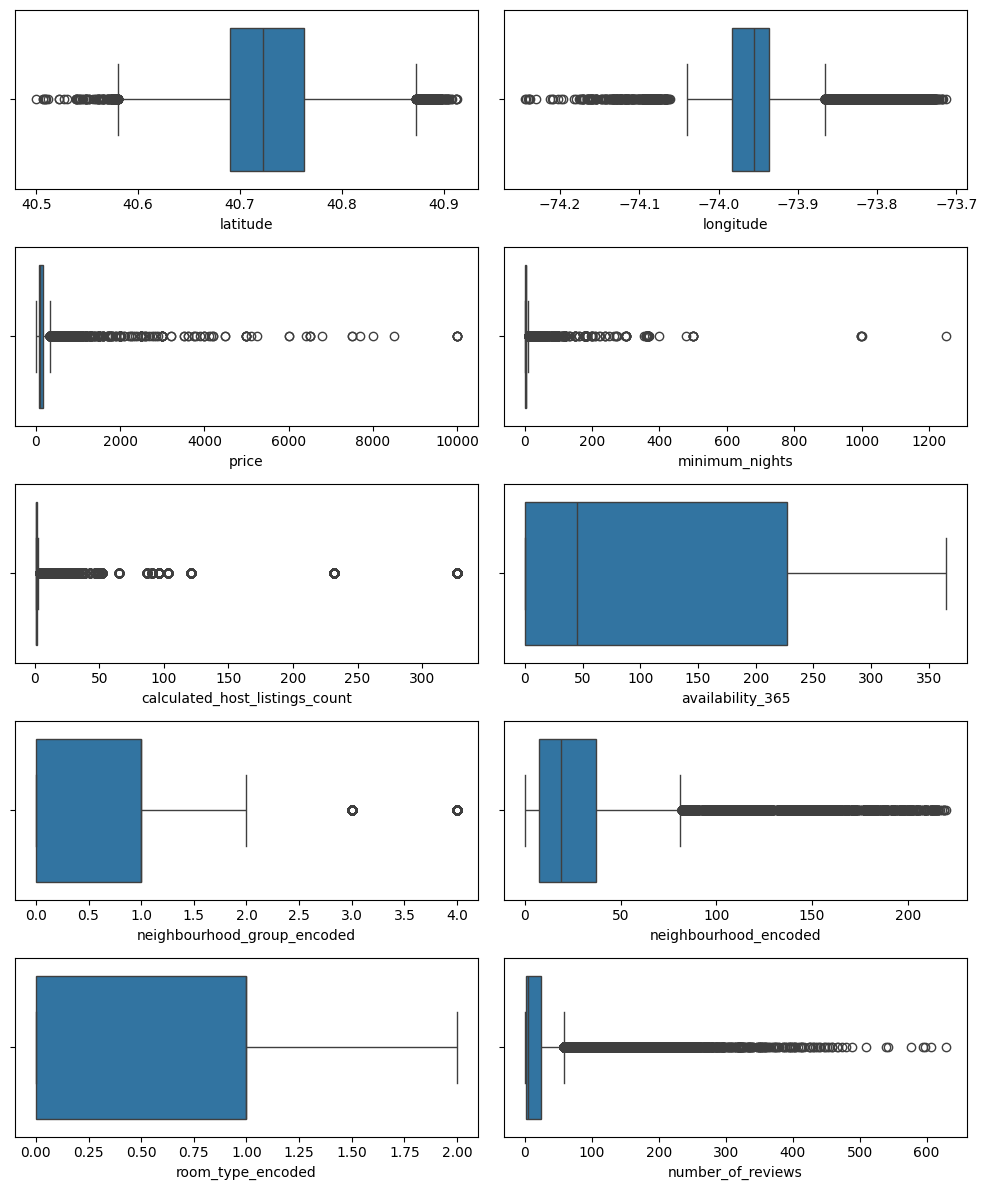

In [148]:
fig, ax = plt.subplots(5, 2, figsize=(10, 12))

sns.boxplot(ax = ax[0,0], data = df_enc, x='latitude')
sns.boxplot(ax = ax[0,1], data = df_enc, x='longitude')

sns.boxplot(ax = ax[1,0], data = df_enc, x='price')
sns.boxplot(ax = ax[1,1], data = df_enc, x='minimum_nights')

sns.boxplot(ax = ax[2,0], data = df_enc, x='calculated_host_listings_count')
sns.boxplot(ax = ax[2,1], data = df_enc, x='availability_365')

sns.boxplot(ax = ax[3,0], data = df_enc, x='neighbourhood_group_encoded')
sns.boxplot(ax = ax[3,1], data = df_enc, x='neighbourhood_encoded')

sns.boxplot(ax = ax[4,0], data = df_enc, x='room_type_encoded')
sns.boxplot(ax = ax[4,1], data = df_enc, x='number_of_reviews')

plt.tight_layout()
plt.show()

In [149]:
# Creating a copy of our df to remove outliers 
df_enc_no = df_enc.copy()

In [150]:
# This function returns our new df without outliers and the features' limits.  
def remove_outliers(x, feature_name, allow_neg=True):
    q1, q3 = x.quantile([0.25, 0.75])
    iqr = q3 - q1
    upper_lim = q3 + (iqr*1.5)
    lower_lim = q1 - (iqr*1.5) if allow_neg else max(0, q1 - (iqr * 1.5))

    x = x.apply(lambda x: upper_lim if (x > upper_lim) else (lower_lim if (x < lower_lim) else x))

    filename = f'./enc/outliers_lims_{feature_name}.json'
    json.dump({'upper_lim': upper_lim, 'lower_lim': lower_lim}, open(filename, 'w'))

    return x

In [151]:
df_enc_no['longitude'] = remove_outliers(df_enc_no['longitude'], 'longitude')
df_enc_no['latitude'] = remove_outliers(df_enc_no['latitude'], 'latitude')
df_enc_no['number_of_reviews'] = remove_outliers(df_enc_no['number_of_reviews'], 'number_of_reviews', allow_neg=False)

### 5.2 Missing Values

In [152]:
df_enc.isna().sum()

latitude                          0
longitude                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
neighbourhood_group_encoded       0
neighbourhood_encoded             0
room_type_encoded                 0
dtype: int64

### 5.3 Split train/test of both Data Frames

In [153]:
def split(target, df, test_size=0.2, random_state=123):
    X = df.drop(columns=target)
    y = df[target]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    return X_train, X_test, y_train, y_test

In [154]:
X_train_with_outliers, X_test_with_outliers, y_train, y_test = split('price', df_enc)
X_train_without_outliers, X_test_without_outliers, y_train_without_outliers, y_test_without_outliers = split('price', df_enc_no)

### 5.4 Normalization

In [155]:
def norm(X_train, X_test, reference: str):
    scaler = StandardScaler()
    scaler.fit(X_train)
    
    X_train_norm = scaler.transform(X_train)
    X_train_norm = pd.DataFrame(X_train_norm, index=X_train.index, columns=X_train.columns)

    X_test_norm = scaler.transform(X_test)
    X_test_norm = pd.DataFrame(X_test_norm, index=X_test.index, columns=X_test.columns)

    dump(scaler, open(f'./enc/normalized_{reference}.sav', 'wb'))

    return X_train_norm, X_test_norm

In [156]:
X_train_with_outliers_norm, X_test_with_outliers_norm = norm(X_train_with_outliers, X_test_with_outliers, 'with_outliers')
X_train_without_outliers_norm, X_test_without_outliers_norm = norm(X_train_without_outliers, X_test_without_outliers, 'without_outliers')

### 5.5 Min - Max Scaling 

In [157]:
def minmax(X_train, X_test, reference: str):
    scaler = MinMaxScaler()
    scaler.fit(X_train)
    
    X_train_minmax = scaler.transform(X_train)
    X_train_minmax = pd.DataFrame(X_train_minmax, index = X_train.index, columns=X_train.columns)

    X_test_minmax = scaler.transform(X_test)
    X_test_minmax = pd.DataFrame(X_test_minmax, index = X_test.index, columns=X_test.columns)
    
    dump(scaler, open(f'./enc/minmax_{reference}.sav', 'wb'))

    return X_train_minmax, X_test_minmax

In [158]:
X_train_with_outliers_minmax, X_test_with_outliers_minmax = minmax(X_train_with_outliers, X_test_with_outliers, 'with_outliers')
X_train_without_outliers_minmax, X_test_without_outliers_minmax = minmax(X_train_without_outliers, X_test_without_outliers, 'without_outliers')

---

## 6 Feature selection

In [159]:
def kselection(X_train, X_test, y_train, k, reference: str):
    selection_model = SelectKBest(f_classif, k=k)
    selection_model.fit(X_train, y_train)
    cols = selection_model.get_support()

    X_train_sel = pd.DataFrame(selection_model.transform(X_train), columns=X_train.columns.values[cols]) 
    X_test_sel = pd.DataFrame(selection_model.transform(X_test), columns=X_test.columns.values[cols])

    dump(selection_model, open(f'./enc/selection_model_{reference}.sav', 'wb'))

    return X_train_sel, X_test_sel   

In [160]:
X_train_with_outliers_sel, X_test_with_outliers_sel = kselection(X_train_with_outliers, X_test_with_outliers, y_train, 7, 'with_outliers')
X_train_without_outliers_sel, X_test_without_outliers_sel = kselection(X_train_without_outliers, X_test_without_outliers, y_train, 7, 'without_outliers')

### 6.1 Applying the filter to the noemalized and minmax scaled data frames

In [161]:
X_train_with_outliers_norm_sel = X_train_with_outliers_norm[X_train_with_outliers_sel.columns]
X_train_without_outliers_norm_sel = X_train_without_outliers_norm[X_train_with_outliers_sel.columns]

X_test_with_outliers_norm_sel = X_test_with_outliers_norm[X_test_with_outliers_sel.columns]
X_test_without_outliers_norm_sel = X_test_without_outliers_norm[X_test_with_outliers_sel.columns]

X_train_with_outliers_minmax_sel = X_train_with_outliers_minmax[X_train_with_outliers_sel.columns]
X_train_without_outliers_minmax_sel = X_train_without_outliers_minmax[X_train_without_outliers_sel.columns]

X_test_with_outliers_minmax_sel = X_test_with_outliers_minmax[X_test_with_outliers_sel.columns]
X_test_without_outliers_minmax_sel = X_test_without_outliers_minmax[X_test_without_outliers_sel.columns]

### 6.2 Saving the CSV files

In [162]:
dfs_train = [X_train_with_outliers_sel, X_train_without_outliers_sel, 
            X_train_with_outliers_norm_sel, X_train_without_outliers_norm_sel, 
            X_train_with_outliers_minmax_sel, X_train_without_outliers_minmax_sel]

dfs_test = [X_test_with_outliers_sel, X_test_without_outliers_sel, 
            X_test_with_outliers_norm_sel, X_test_without_outliers_norm_sel, 
            X_test_with_outliers_minmax_sel, X_test_without_outliers_minmax_sel]

for df in dfs_train:
    df['price'] = list(y_train)

for df in dfs_test:
    df['price'] = list(y_test)

/tmp/ipykernel_3091/1931256352.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['price'] = list(y_train)
/tmp/ipykernel_3091/1931256352.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['price'] = list(y_train)
/tmp/ipykernel_3091/1931256352.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexin

### 6.3 Training

In [163]:
# Train data frames
X_train_with_outliers_sel.to_csv('./enc/X_train_with_outliers_sel.csv', index=False)
X_train_without_outliers_sel.to_csv('./enc/X_train_without_outliers_sel.csv', index=False)
X_train_with_outliers_norm_sel.to_csv('./enc/X_train_with_outliers_norm_sel.csv', index=False)
X_train_without_outliers_norm_sel.to_csv('./enc/X_train_without_outliers_norm_sel.csv', index=False)
X_train_with_outliers_minmax_sel.to_csv('./enc/X_train_with_outliers_minmax_sel.csv', index=False)
X_train_without_outliers_minmax_sel.to_csv('./enc/X_train_without_outliers_minmax_sel.csv', index=False)

# Test data frames
X_test_with_outliers_sel.to_csv('./enc/X_test_with_outliers_sel.csv', index=False)
X_test_without_outliers_sel.to_csv('./enc/X_test_without_outliers_sel.csv', index=False)
X_test_with_outliers_norm_sel.to_csv('./enc/X_test_with_outliers_norm_sel.csv', index=False)
X_test_without_outliers_norm_sel.to_csv('./enc/X_test_without_outliers_norm_sel.csv', index=False)
X_test_with_outliers_minmax_sel.to_csv('./enc/X_test_with_outliers_minmax_sel.csv', index=False)
X_test_without_outliers_minmax_sel.to_csv('./enc/X_test_without_outliers_minmax_sel.csv', index=False)